# PKD10 RC/RC: single cell analysis QC 
**March, 2024** <br>
Goals:<br>
* Load samplees from CellRanger (featured_feature_bc_h5 file)
* Find optimal QC thresholds across samples
* Find which samples are high quality
* Export an h5ad object with basic processing (QC, clustering, UMAP, etc.) 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import os
import scanpy as sc
import glob
import sys
import re 
import anndata as ad


# Scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=150)

Global variables: File Directories <br> 
**Replace the path with the location of your files**

In [3]:
COUNTS_DIR = '/group/genomics/scripts/CellRanger/REQ_23_002/reseq/rerun/' # count matrices from CellRanger
ATLAS_DIR = '/home/nehamurad/PAPP-A/PKD10_RCRC/RCRC_adata/'   # Save concatenated h5ad here 

# 1. Load CellRanger files and generate adata objects

We assume that all count matrices from CellRanger are located in the same directory, with a sub-folder for each sample (sequencing run)<br>
The directory has a specific structure that will depend on the project and how the data was organized <br>
Pay attention to the **sub-folder structure** since it will affect how the following code will perform. 

In [ ]:
# Let's extract the folder structure for this project 
# For PKD10 fl/fl, we have all count matrices in the same directory
mtx10X = glob.glob(COUNTS_DIR + '*/') # give list of all folders in the sub folder
mtx10X.sort()

In [ ]:
len(mtx10X) #matches number of samples

In [ ]:
# Let's look at the folder names for all the samples
mtx10X

Let's check that we have the correct samples:

In [ ]:
keep_samples = mtx10X # add path upto filteered_bc h5
keep_samples

### Load metadata csv -- mandatory 

Here we load a data frame with metadata for the project. We can then merge the metadata with the sequencing data to create a final object.


In [4]:
META_PATH = '/home/nehamurad/PAPP-A/PKD10_RCRC//'
META_FILE = 'pkd10metadata_rcrc_03142024.csv'
meta_df = pd.read_csv(META_PATH + META_FILE ) 

# replace whitespace in the column names 
meta_df.columns = meta_df.columns.str.strip()
meta_df.columns = meta_df.columns.str.replace(" ", "_")
meta_df.columns = meta_df.columns.str.lower()

In [ ]:
meta_df.head() 

<span style="color:blue">Function definition</span> <br>
This cell creates a function that we will use later, it doesn't print anything. 
<br>


In [ ]:
# This function takes the file path, sample names, with some basic QC thresholds, 
# then load all h5 count matrices, concatenates them, then create one joint anndata file
def loadH5Folder(main_path='',           # path to h5 file (long name with subfolders)
                 sample_name = "",       # must be provided by the user 
                 min_genes_pcell = 100,  # basic QC 
                 min_counts_pcell = 100, # basic QC 
                ):
      
        adataaux = sc.read_10x_h5(main_path +'outs/filtered_feature_bc_matrix.h5') #outs folder added
       
        adataaux.var_names_make_unique() 
        # Do basic filtering -- not QC! This is only to reduce the size of the file 
        sc.pp.filter_cells(adataaux, min_genes=min_genes_pcell)
        sc.pp.filter_cells(adataaux, min_counts=min_counts_pcell)
        
        # Add the sample name 
        adataaux.obs['sample_ID'] = sample_name[:-8]
        # make a unique cell_id by including the sample ID to avoid duplicates 
        adataaux.obs['cell_id'] = adataaux.obs['sample_ID'] + "_" + adataaux.obs.index
        
        # Set the unique cell_id as index for adata.obs
        adataaux.obs = adataaux.obs.set_index("cell_id")
      
        return adataaux

## 1.2 Read and concatenate 
Let's read each adata object using Scanpy and save them into a list of adata objects. <br>
We can then concatenate all the objects into a **single adata object**.

In [ ]:
%%capture

adata_list = list() 

for path in keep_samples:
    
    sample_id  = path.split('/')[-2]
    adata_aux = loadH5Folder(main_path = path, sample_name = sample_id, 
                            min_genes_pcell = 1, 
                            min_counts_pcell = 10 )
    
    adata_list.append(adata_aux)

In [ ]:
import anndata as ad

# merge = "same" keeps columns in adata
adata = ad.concat(adata_list,merge="same")

Check that metadata is correct in the concatenated object

In [ ]:
adata.var.head() 

The adata.obs data frame contains metadata for each cell. We parsed this information from the sub-folder structure. However, a best practice would be to import this information from a .csv file and use pandas to join the data frames. 
<br>
The **sample_ID** should be unique for each sequencing run, in this case a fl/fl mouse

In [ ]:
adata.obs.head() 

<span style="color:blue">Function definition</span> <br>
This cell creates a function that we will use later, it doesn't print anything. 
<br>


In [ ]:
# Description of the function goes here:
# this function addes the metadata information to the adata object in the adata.obs slot
def add_metadata(adata_obj = [], 
                 metadata_df = [],                     # a data frame with all the metadata -- it must have the sample ID colum  
                 sample_index = 'sample_name',              # for zebrafish -- other examples: donor_id, sample_number, sample, sample_name, etc. 
                 cols_to_add = ['group','treatment']  # the list of columns that we want to add to the adata object, it should be a subset of metadata_df.columns
                ):


    cols_to_add = [sample_index] + cols_to_add
    #adata_obj.obs.rename(columns = {'sample_ID':sample_index }, inplace = True)
    
    # Let's duplicate the sample_ID column (which is mandatory) and use the user-define name (project-specific) 
    adata_obj.obs[sample_index] = adata_obj.obs.sample_ID
    # let's reset the index and add it as a column 
    adata_obj.obs.reset_index(inplace = True)
    # merge with metadata 
    df = pd.merge( adata_obj.obs, metadata_df[cols_to_add], 
#                                   left_index = True, right_on = sample_index,how = 'left') 
                                  on = sample_index, how = 'left')

    df.index = df.index.astype(str)
    # update obs 
    adata_obj.obs = df
    # set the index again 
    adata_obj.obs.set_index('cell_id', inplace = True)
    
    #returns updated adata object 
    return adata_obj

In [ ]:
adata.obs

In [ ]:
meta_df.head()

In [ ]:
adata_ann = add_metadata(adata_obj = adata.copy() , metadata_df = meta_df, sample_index = 'sample_name',              # for zebrafish -- other examples: donor_id, sample_number, sample, sample_name, etc. 
                 cols_to_add = ['group','treatment','sex'])

In [ ]:
adata_ann

In [ ]:
adata_ann.obs.head() 

In [ ]:
adata_ann.obs.tail() 

In [ ]:
adata_ann.obs.group.unique()

In [ ]:
adata_ann.obs.treatment.unique()

In [ ]:
len(adata_ann.obs.sample_name.unique())

## 1.3 Checkpoint: Save the raw data 
Although we haven't performed the Quality control yet, we can save the concatenated object for future reference or if the QC needs to be fine tuned. <br>
By saving the object at this point we won't need to re-run the previous sections. <br>
The raw object can be loaded into CellXGene or in a different Python notebook !

In [ ]:
ATLAS_DIR

In [ ]:
# SET the output directory to save your UNPROCESSED object 
# This adata object has only basic QC, so we call it "raw"
from datetime import date
today = date.today()

# mm/dd/y
d = today.strftime("%m%d%y")
print("date =", d)

adata_ann.write(ATLAS_DIR + d+'_raw.h5ad')

We can now check that the metadata corresponds to the sample information <br>
In this case, we can check the developmental stage (time point) but for other projects we might be interested in donor, organ, or biological condition. <br>

In [ ]:
# adata_ann.obs.time_point.value_counts() 

In [ ]:
# adata_ann.obs.sample_ID.value_counts()

# 2. Start QC

In [6]:
#When re-runnign notebook just load raw anndata file
adata_ann = ad.read_h5ad("RCRC_adata/031424_raw.h5ad")
adata_ann

AnnData object with n_obs × n_vars = 256905 × 32285
    obs: 'n_genes', 'n_counts', 'sample_ID', 'sample_name', 'group', 'treatment', 'sex'
    var: 'gene_ids', 'feature_types', 'genome'

In [7]:
adata = adata_ann.copy()

## 2.1 Histogram of counts per cell 

* We show a main histogram with all counts from mice -- and we show a couple of trhesholds that should be good for 10x data. 
* We can also tell the user how many cells will be lost after applying such thresholds
* Finally, we can make a grid of histograms showing each sample (mouse) and thre thresholds so we can see problematic samples 

In [8]:
adata.obs.head() 

n_genes  n_counts   sample_ID sample_name  \
cell_id                                                                    
1pt1WT_IgG_AAACCCAAGAATCTAG-1     3902   12578.0  1pt1WT_IgG  1pt1WT_IgG   
1pt1WT_IgG_AAACCCAAGGTTGGAC-1      477     727.0  1pt1WT_IgG  1pt1WT_IgG   
1pt1WT_IgG_AAACCCAAGTAATCCC-1     3390    8262.0  1pt1WT_IgG  1pt1WT_IgG   
1pt1WT_IgG_AAACCCAAGTGGACGT-1     3924   12848.0  1pt1WT_IgG  1pt1WT_IgG   
1pt1WT_IgG_AAACCCACAAGCTGTT-1     2983    8614.0  1pt1WT_IgG  1pt1WT_IgG   

                                group treatment   sex  
cell_id                                                
1pt1WT_IgG_AAACCCAAGAATCTAG-1  WT_IgG       IgG  male  
1pt1WT_IgG_AAACCCAAGGTTGGAC-1  WT_IgG       IgG  male  
1pt1WT_IgG_AAACCCAAGTAATCCC-1  WT_IgG       IgG  male  
1pt1WT_IgG_AAACCCAAGTGGACGT-1  WT_IgG       IgG  male  
1pt1WT_IgG_AAACCCACAAGCTGTT-1  WT_IgG       IgG  male

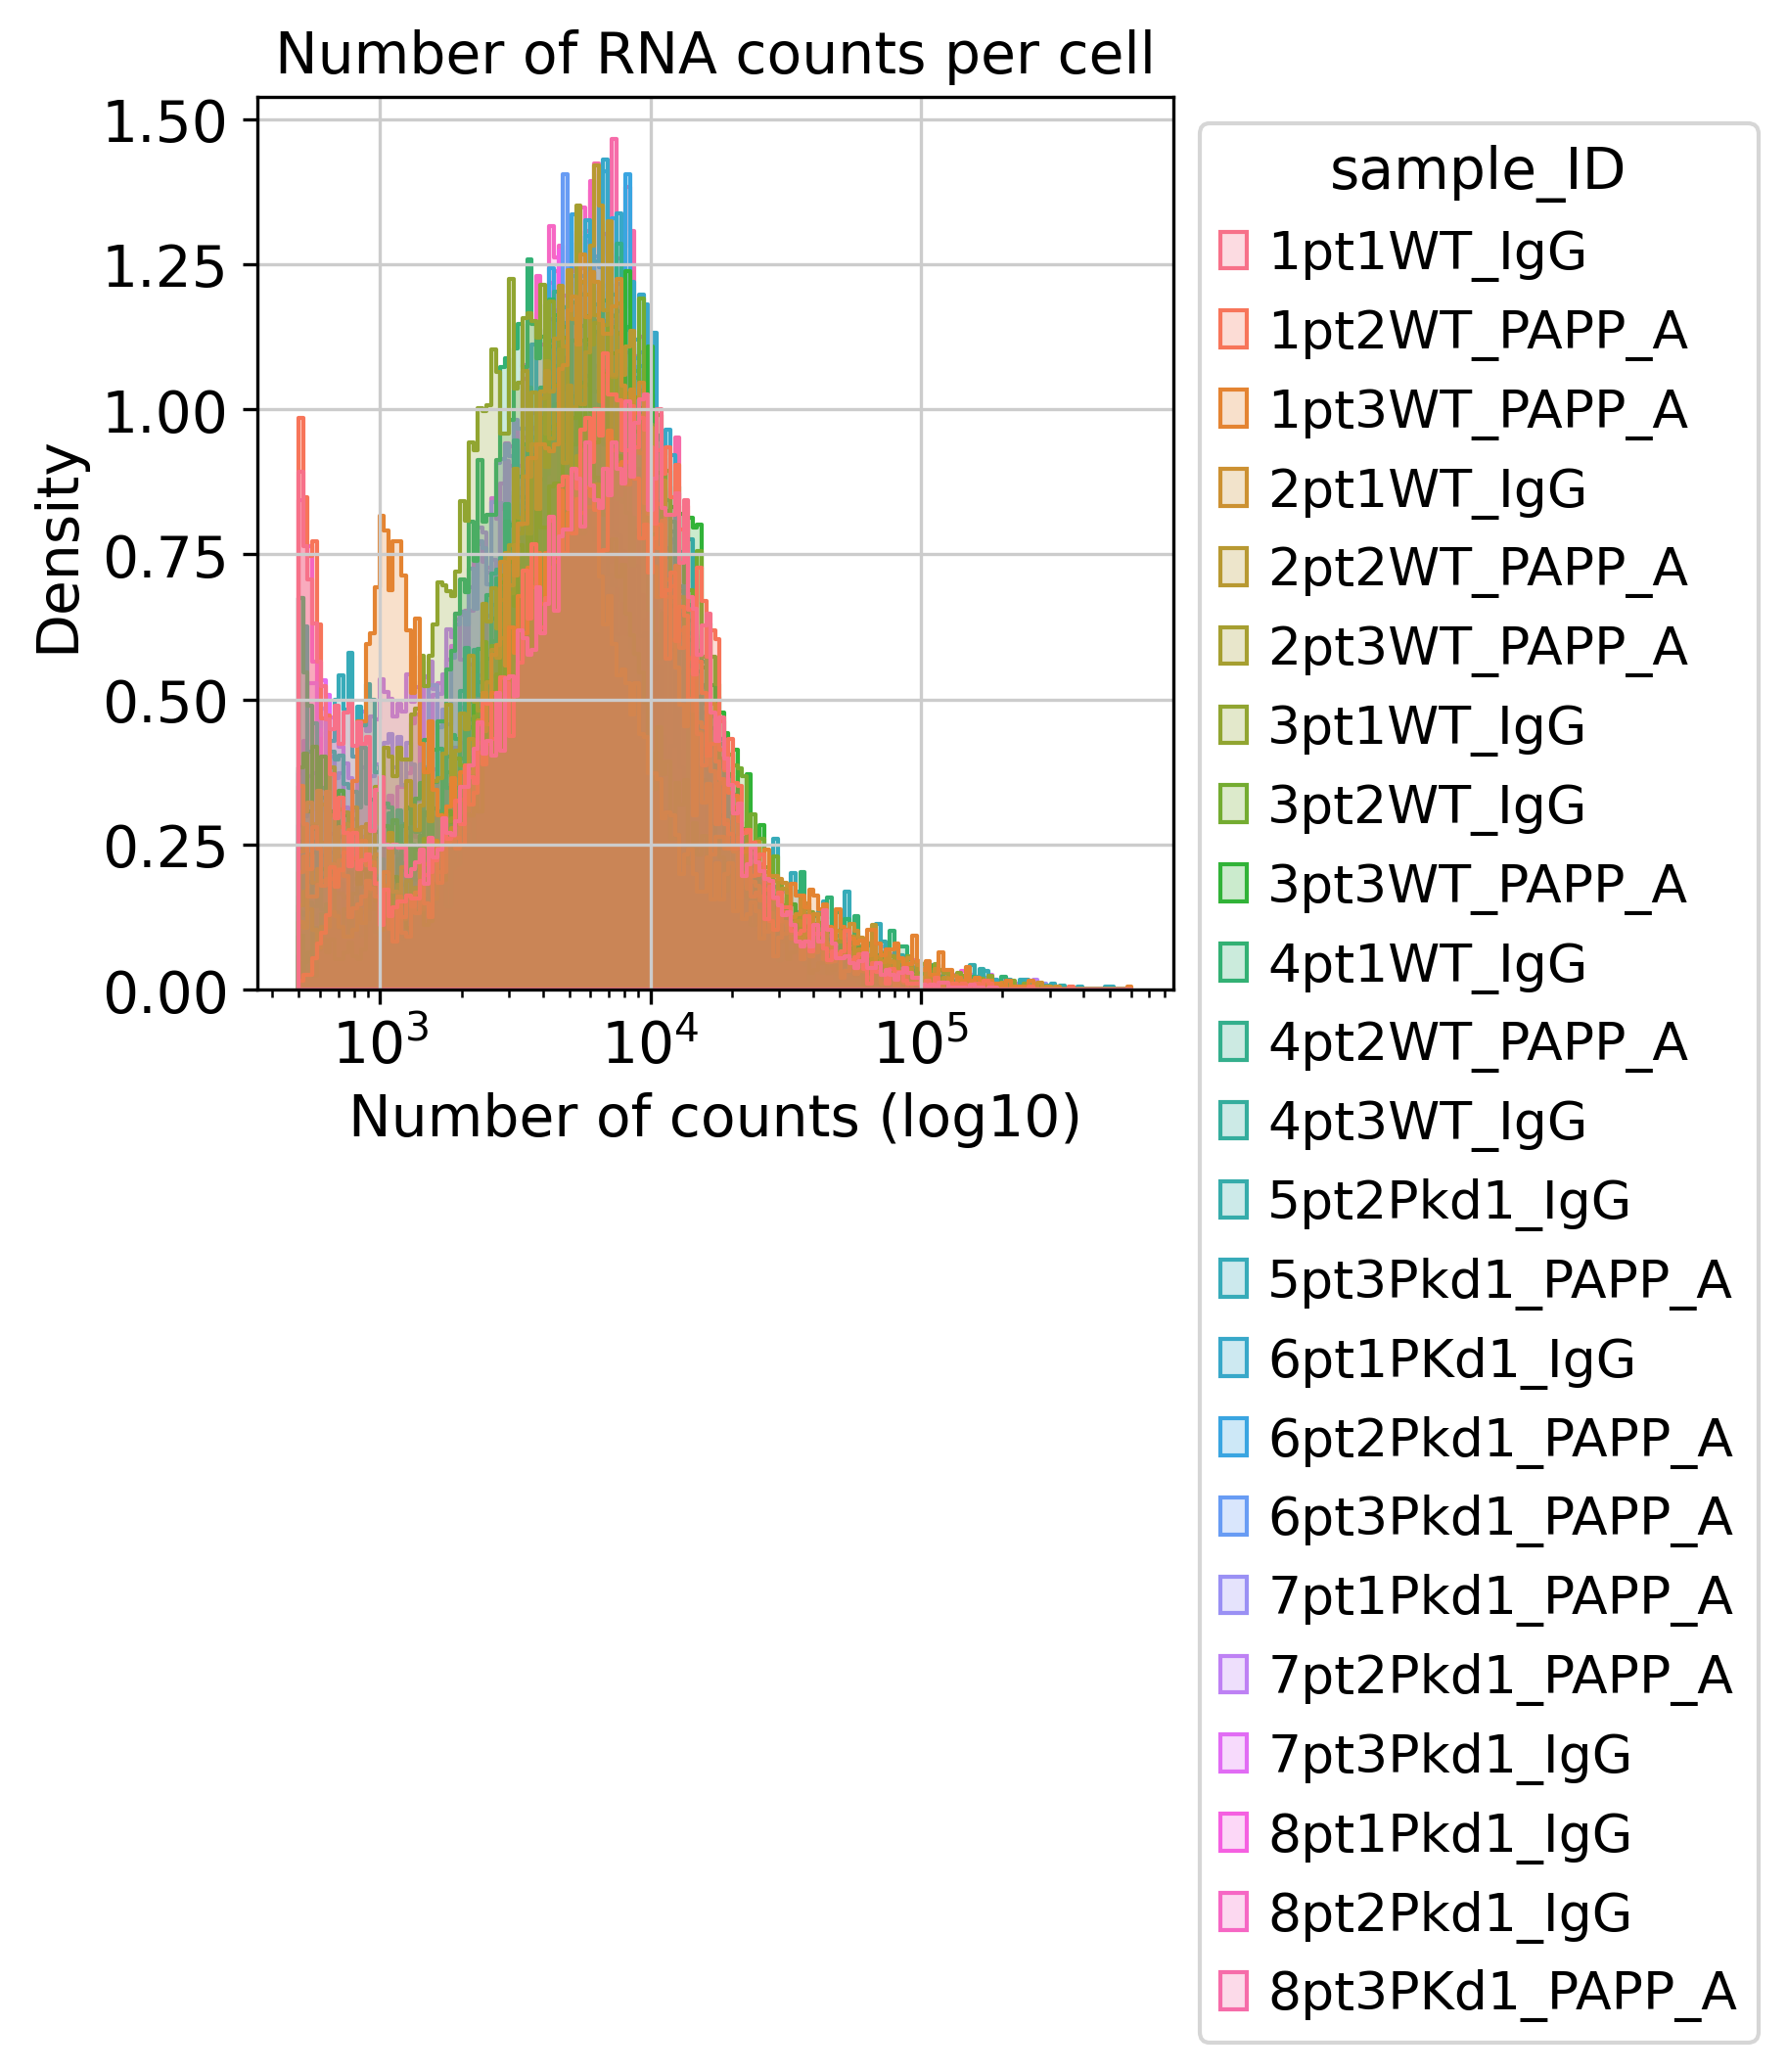

In [9]:
# Plot the histogram
ax = sns.histplot(adata.obs, x = 'n_counts',
             element="step", common_norm=False, kde=False, stat="density", 
             log_scale=True, hue="sample_ID", label = 'sample_ID')

ax.set_title('Number of RNA counts per cell') 
ax.set(xlabel="Number of counts (log10)") 

# Place the legend outside the plot
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## 2.2 Number of genes per cell 

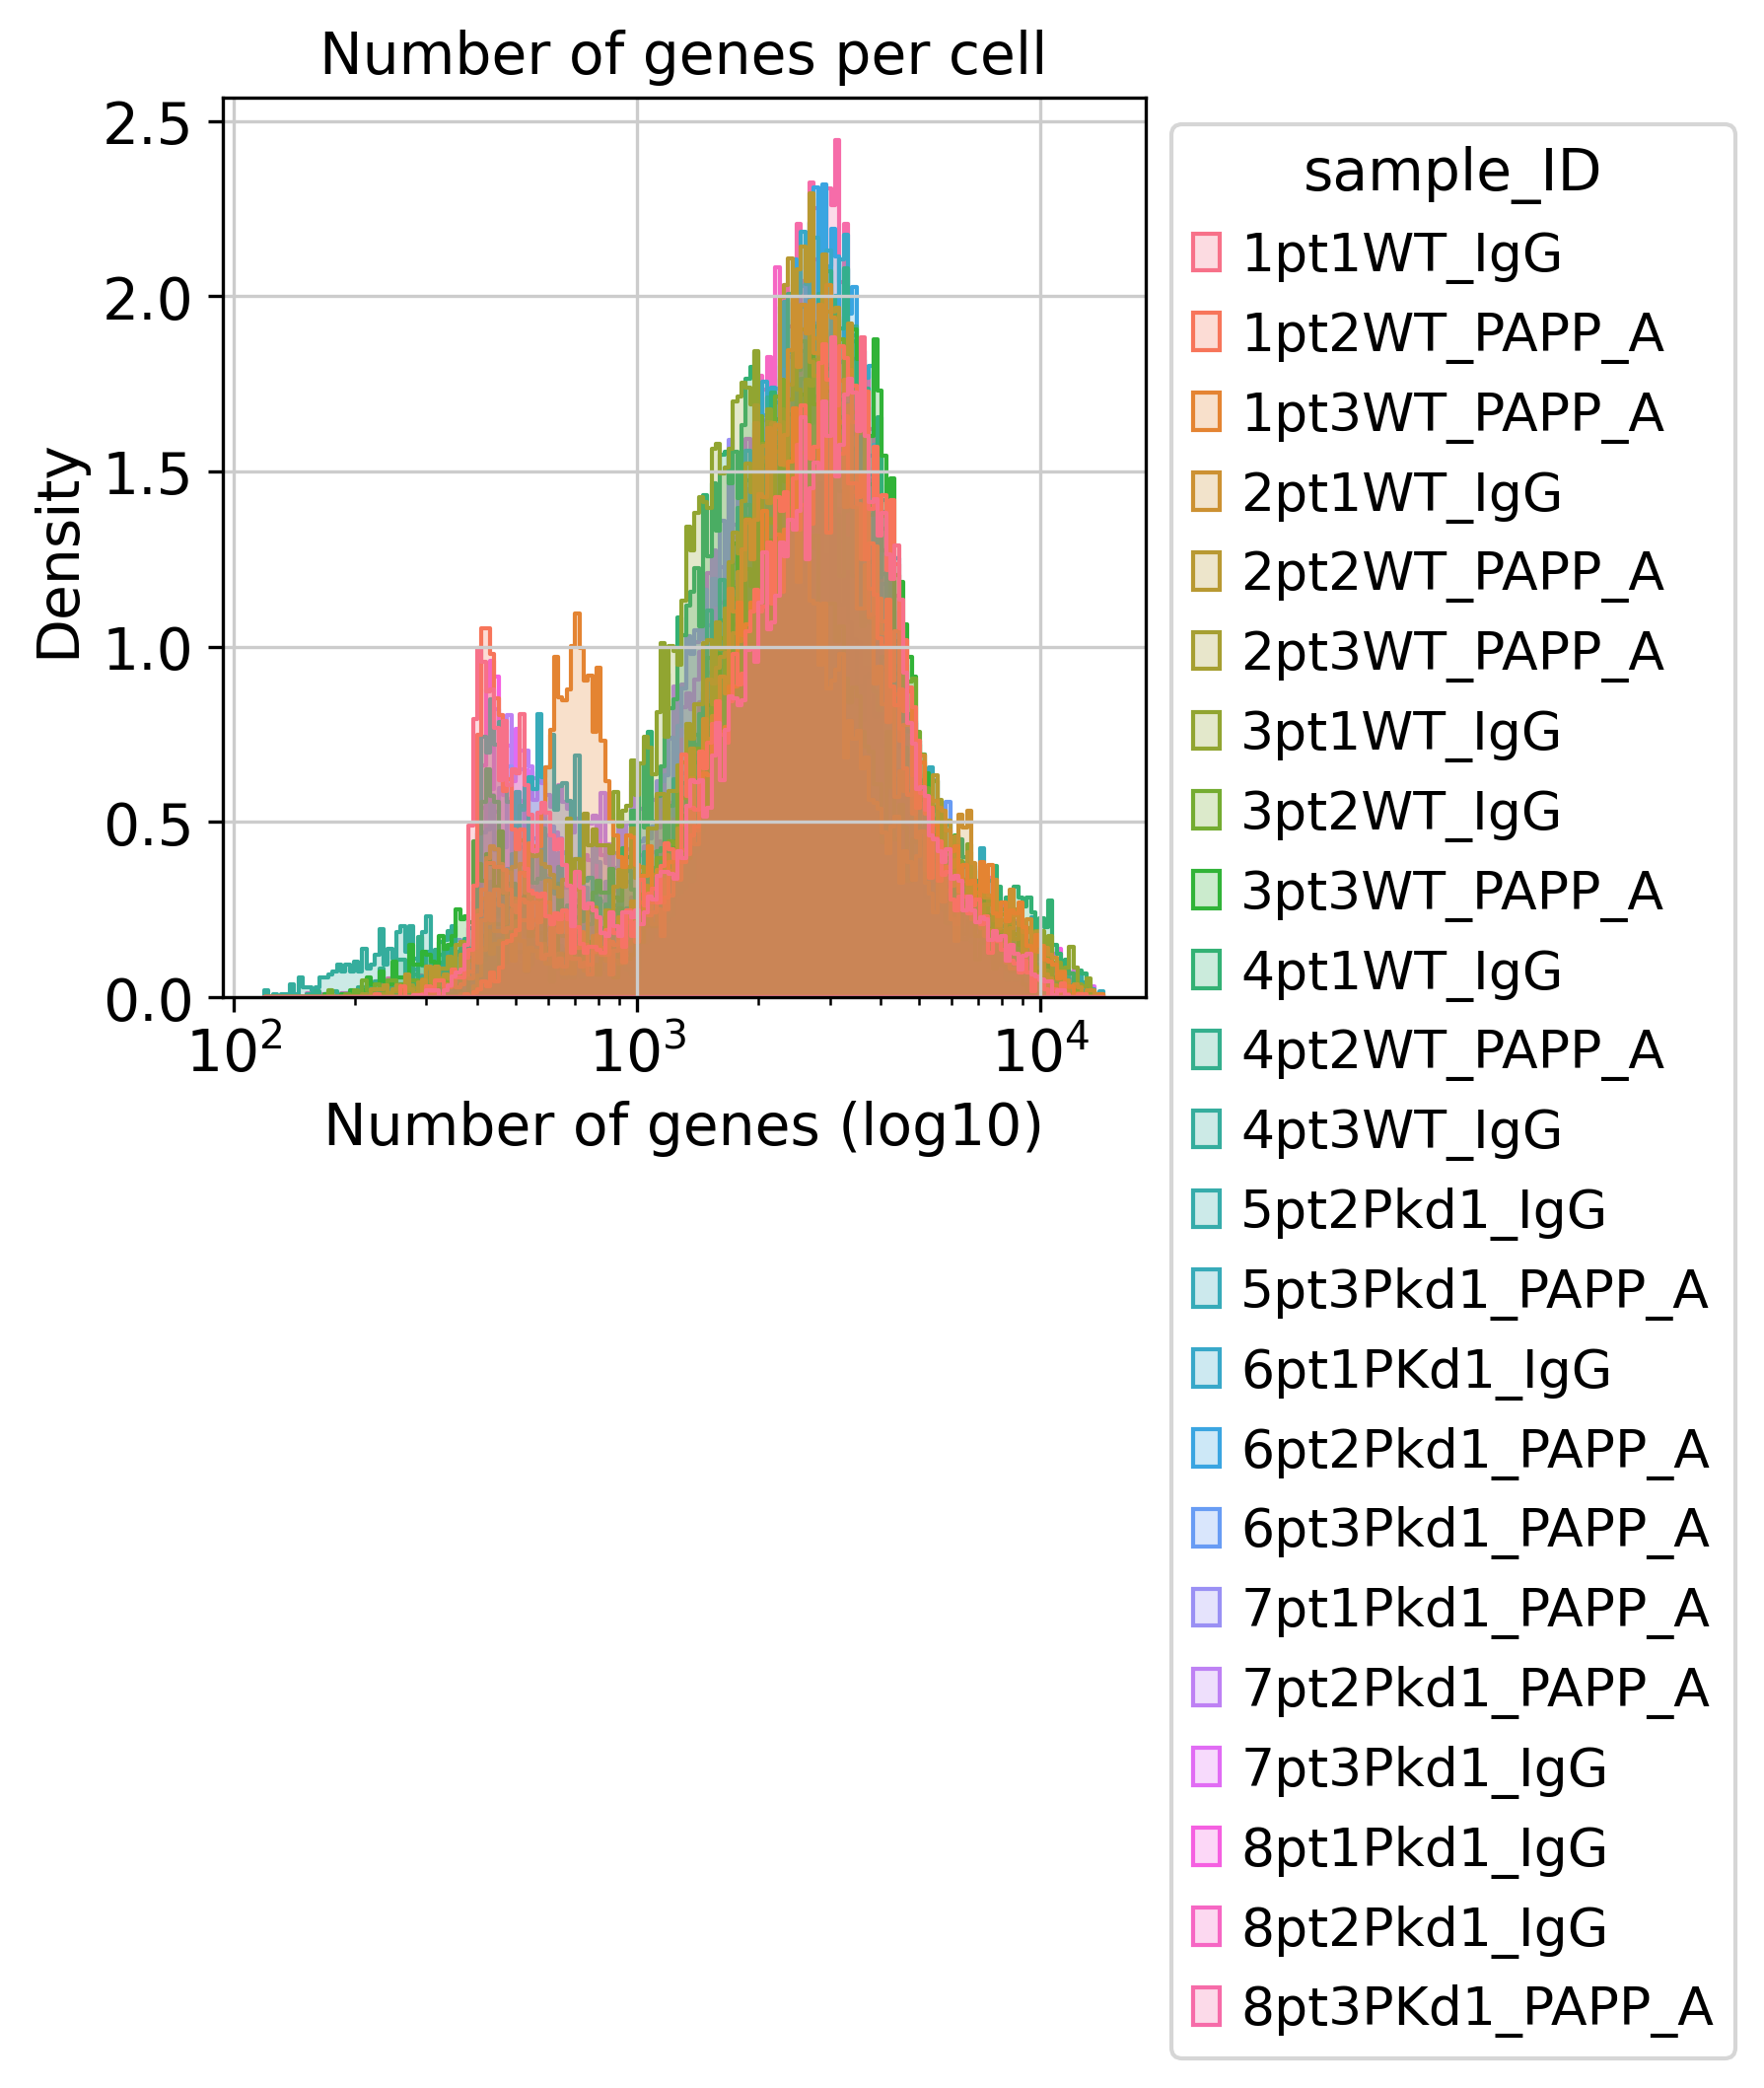

In [10]:
# Plot the histogram
ax = sns.histplot(adata.obs, x = 'n_genes',
             element="step", common_norm=False, kde=False, stat="density", 
             log_scale=True, hue="sample_ID")
ax.set_title("Number of genes per cell") 
ax.set(xlabel="Number of genes (log10)") 

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Step1. Finding out QC thresholds for multiple embryos altogether 
### Let's zoom in the distribution

We want to take a closer look at the lower count regime, let's zoom into that region.
First, we will check the histogram from 4 fish samples to identify if there's any multimodal peaks and troughs that show differnt populations of cells.

[Text(0.5, 0, 'Number of counts (log10)')]

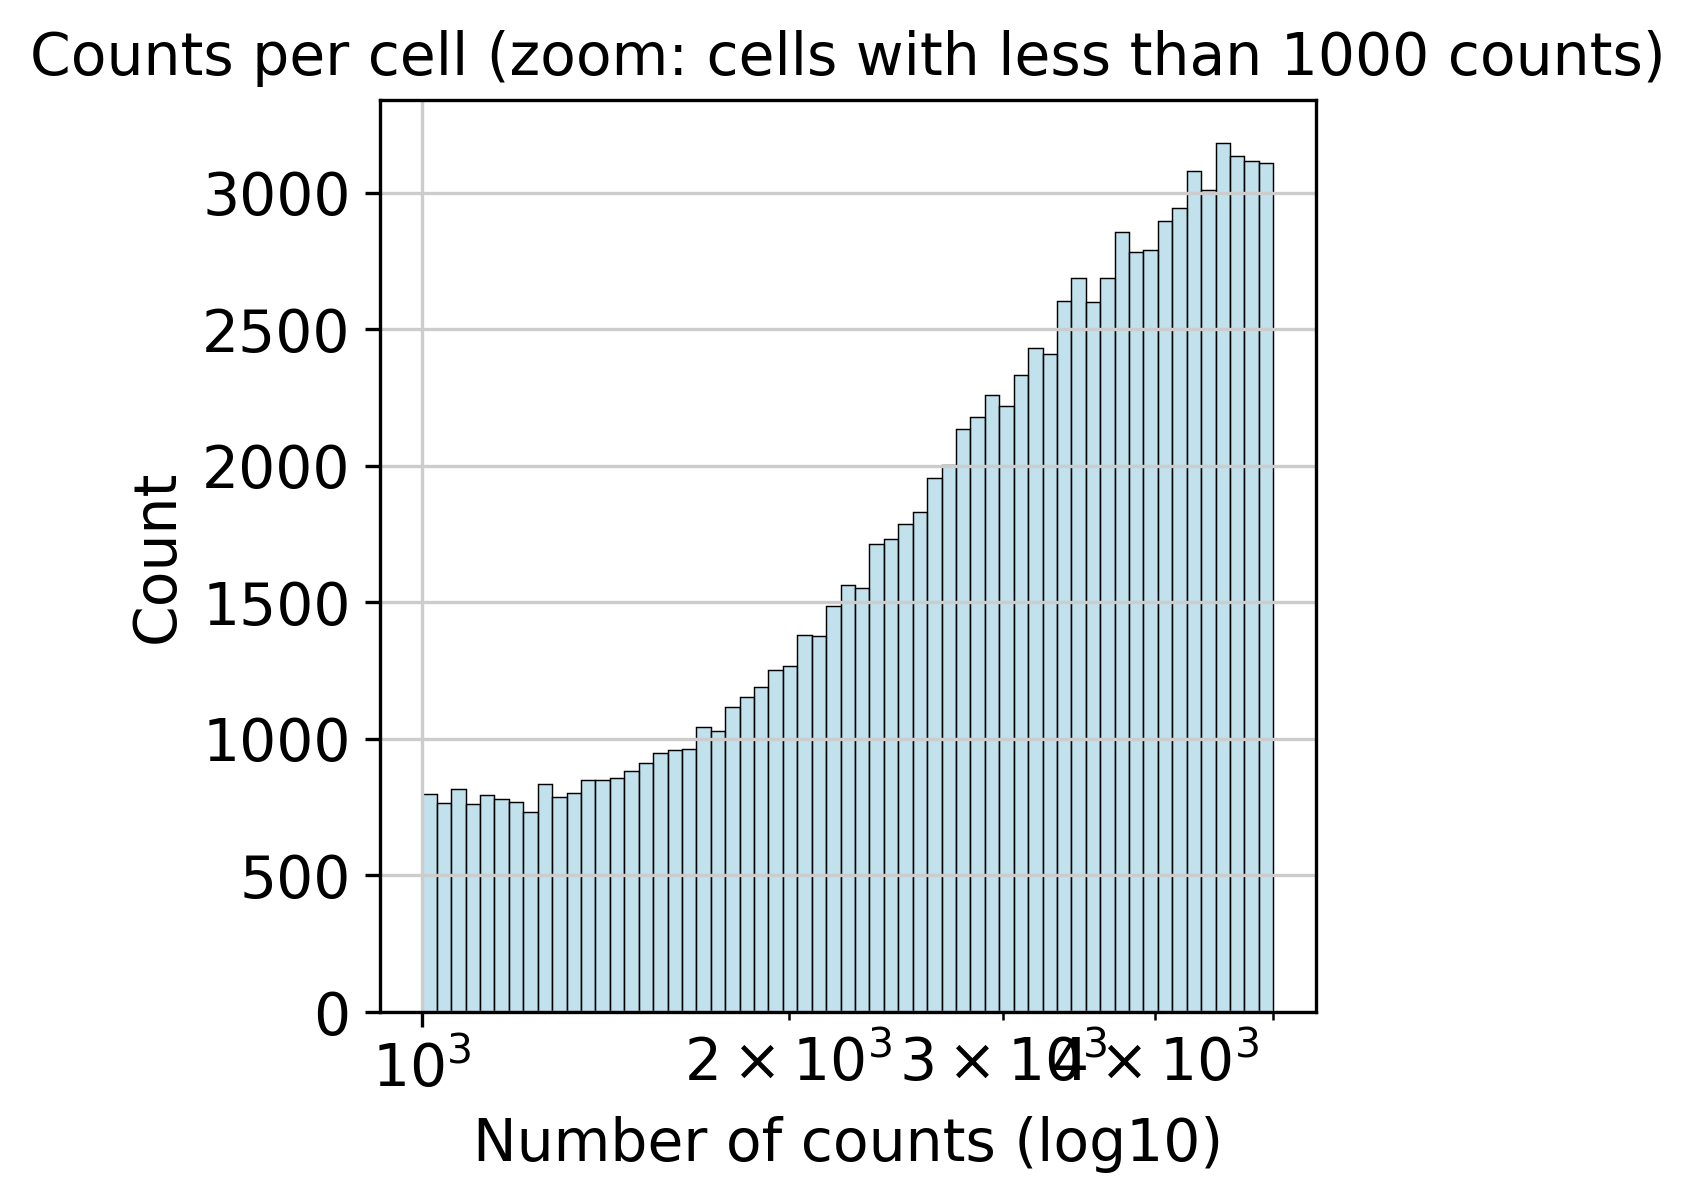

In [11]:
# Histogram of the number of counts per cell
# find a good range to zoom in! 

min_count_plot = 1000
max_count_plot = 5000
ax = sns.histplot(data = adata[(adata.obs["n_counts"]> min_count_plot) & (adata.obs["n_counts"]< max_count_plot) ].obs, 
                  x ='n_counts', color = 'lightblue', 
                  log_scale=True)

ax.set_title("Counts per cell (zoom: cells with less than " + str(min_count_plot) + " counts)" ) 
ax.set(xlabel="Number of counts (log10)") 

Use the above histogram to **find a good threshold**. We want a threshold on the number of counts that separates bad (low) from good (high) cells. <br>
<span style="color:red">NOTE:</span> <br>
Find the threshold that would split the distribution into two from the above plot. Finding the cut-off is easier if the distribution is naturally bimodal but can get tricky when there is no clear bimodality. 

#### Let's propose a couple of thresholds and plot how many cells would be filtered out

256905 cells exist in this dataset


[Text(0.5, 0, 'Number of counts (log10)'), Text(0, 0.5, 'Number of cells')]

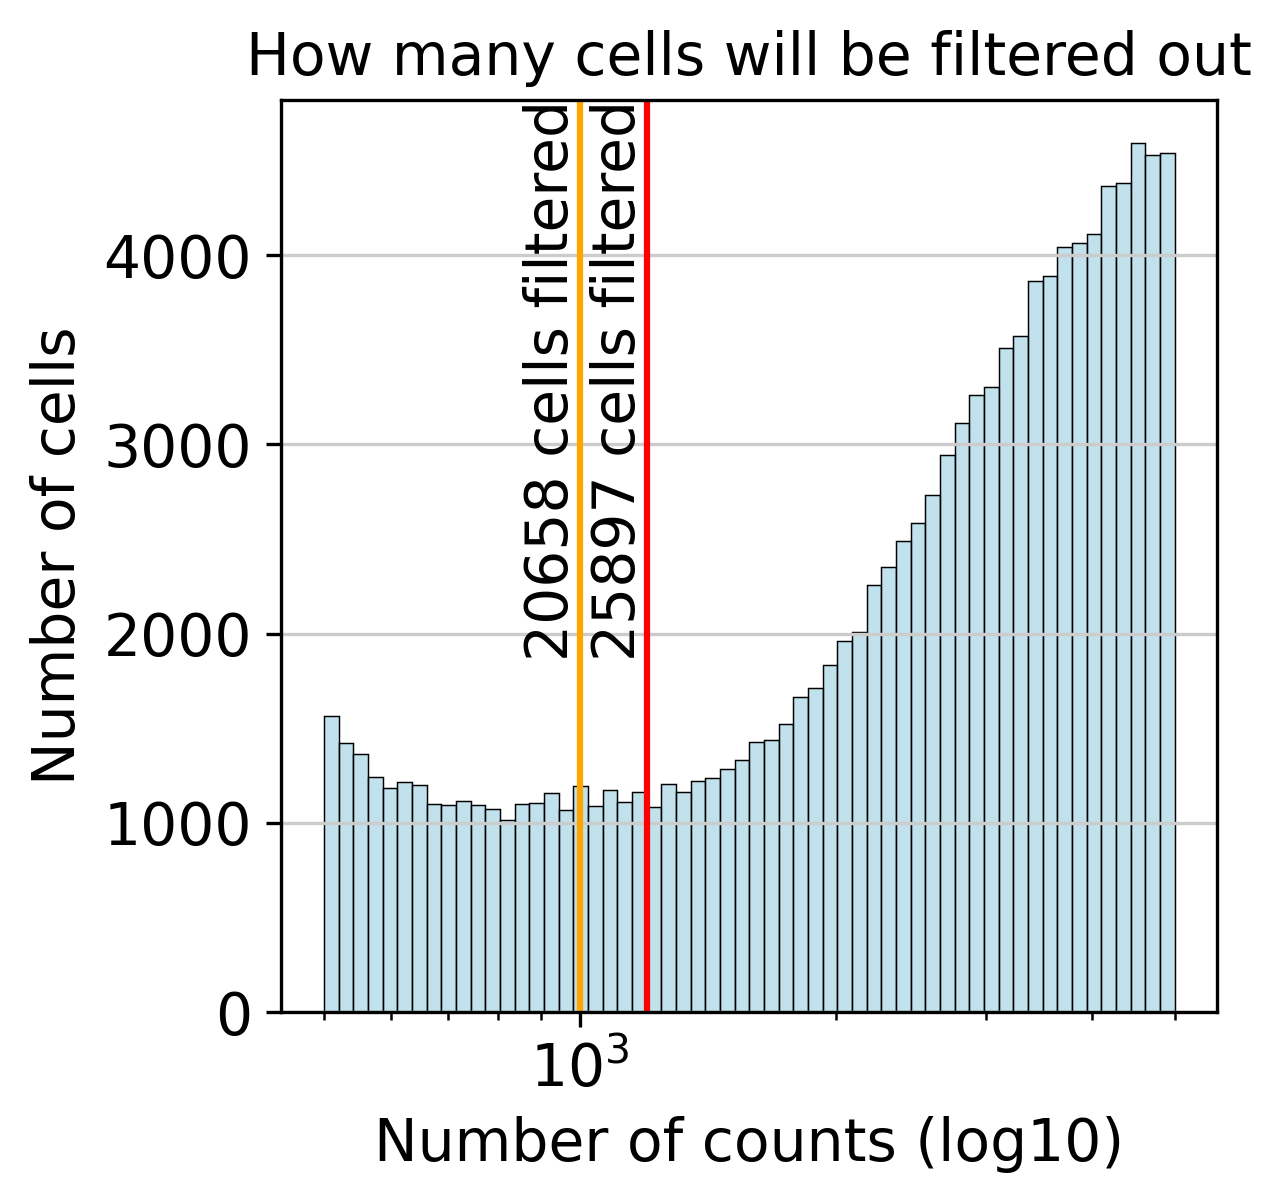

In [12]:
# Histogram of the number of counts per cell

ax = sns.histplot(data = adata[adata.obs["n_counts"]<max_count_plot].obs, 
                  x ='n_counts',color='lightblue',
                  log_scale=True)

# total number of cells
print(str(adata.n_obs) + " cells exist in this dataset")

# compute how many cells will be filtered out for different thresholds
thresh1 = 1000
thresh2 = 1200

n_cells_filtered_1 = adata[adata.obs["n_counts"]<thresh1].n_obs
n_cells_filtered_2 = adata[adata.obs["n_counts"]<thresh2].n_obs

# plot vertical lines for the thresholds as well as the number of cells filtered out with those thresholds
plt.axvline(x=thresh1, color='orange',)
plt.text(thresh1, plt.ylim()[1], str(n_cells_filtered_1)+' cells filtered', rotation=90, va='top', ha='right')
plt.axvline(x=thresh2, color='red')
plt.text(thresh2, plt.ylim()[1], str(n_cells_filtered_2)+' cells filtered', rotation=90, va='top', ha='right')

ax.set_title("How many cells will be filtered out" ) 
ax.set(xlabel="Number of counts (log10)", ylabel = "Number of cells") 


## Step2: Check the thresholds for individual samples to assess heterogeneity
Are there any **(bad) samples** that clearly show a different pattern? <br>
Can we tailor the threshold so that most samples are included after the filtering? <br>

In [14]:
# Let's plot a grid of histograms 
# one per sample, and draw the thresholds as vertical lines 

# get the number of samples (fishes)
num_samples = adata.obs.sample_ID.nunique()
num_samples

list_samples = list(adata.obs.sample_ID.unique())
list_samples

# We will create N x N subplots where N^2 >= number of samples
num_rows = int(np.ceil(np.sqrt(num_samples)))
num_cols = int(np.ceil(np.sqrt(num_samples)))

fig, axes = plt.subplots(num_rows,num_cols)

# Flatten the array of axes
axes = axes.ravel()

# Use a for loop to add a specific plot to each panel
for i, ax in enumerate(axes):
    
    if i<len(list_samples):
    # subset the anndata for individual sample (fish)
        adata_sub = adata[adata.obs["sample_ID"]==list_samples[i]]
        
        ax.set_xscale('log')
        ax.hist(adata_sub[adata_sub.obs["n_counts"]<max_count_plot].obs['n_counts'], 
                color = 'lightblue',
               bins = 100)
        # compute the number of cells that will be filtered by thresholds
        n_cells_filtered_1 = adata_sub[adata_sub.obs["n_counts"]<thresh1].n_obs
        n_cells_filtered_2 = adata_sub[adata_sub.obs["n_counts"]<thresh2].n_obs


        pos_text = 'bottom'
        # plot vertical lines for the thresholds as well as the number of cells filtered out with those thresholds
        ax.axvline(x=thresh1, color='orange')
        ax.text(thresh1, ax.get_ylim()[0], str(n_cells_filtered_1)+' cells filtered', rotation=90, va=pos_text, ha='right')

        ax.axvline(x=thresh2, color='red')
        ax.text(thresh2, ax.get_ylim()[0], str(n_cells_filtered_2)+' cells filtered', rotation=90, va=pos_text, ha='right')
        ax.set_xlabel("counts p cell")
        ax.set_ylabel("number of cells")
        ax.set_title("sample: " + str(list_samples[i]))


# Adjust the layout
# plt.tight_layout()

# Adjust the font size
plt.rcParams.update({'font.size': 12})
# plt.subplots_adjust(hspace=1.0)

# Increase the figure size
fig.set_size_inches(6*num_rows, 6*num_cols)

# Display the figure
# plt.show()


From this observation, we can conclude that there was no particularly bad fish (sample) from our datasets. To be generous about the QC thresholds, we probably pick the **lower threshold of 10,000 counts per cell**

## 2.3 Applying filters and saving QC'd object

* Let's find the fraction of mitochondrial genes per cell 
* We want to filter out cells with high content of mitochrondrial genes 
* In Zebrafish, mitochondrial genes can be found easily because their name starts with "mt" or "NC"

normalizing counts per cell
    finished (0:00:13)


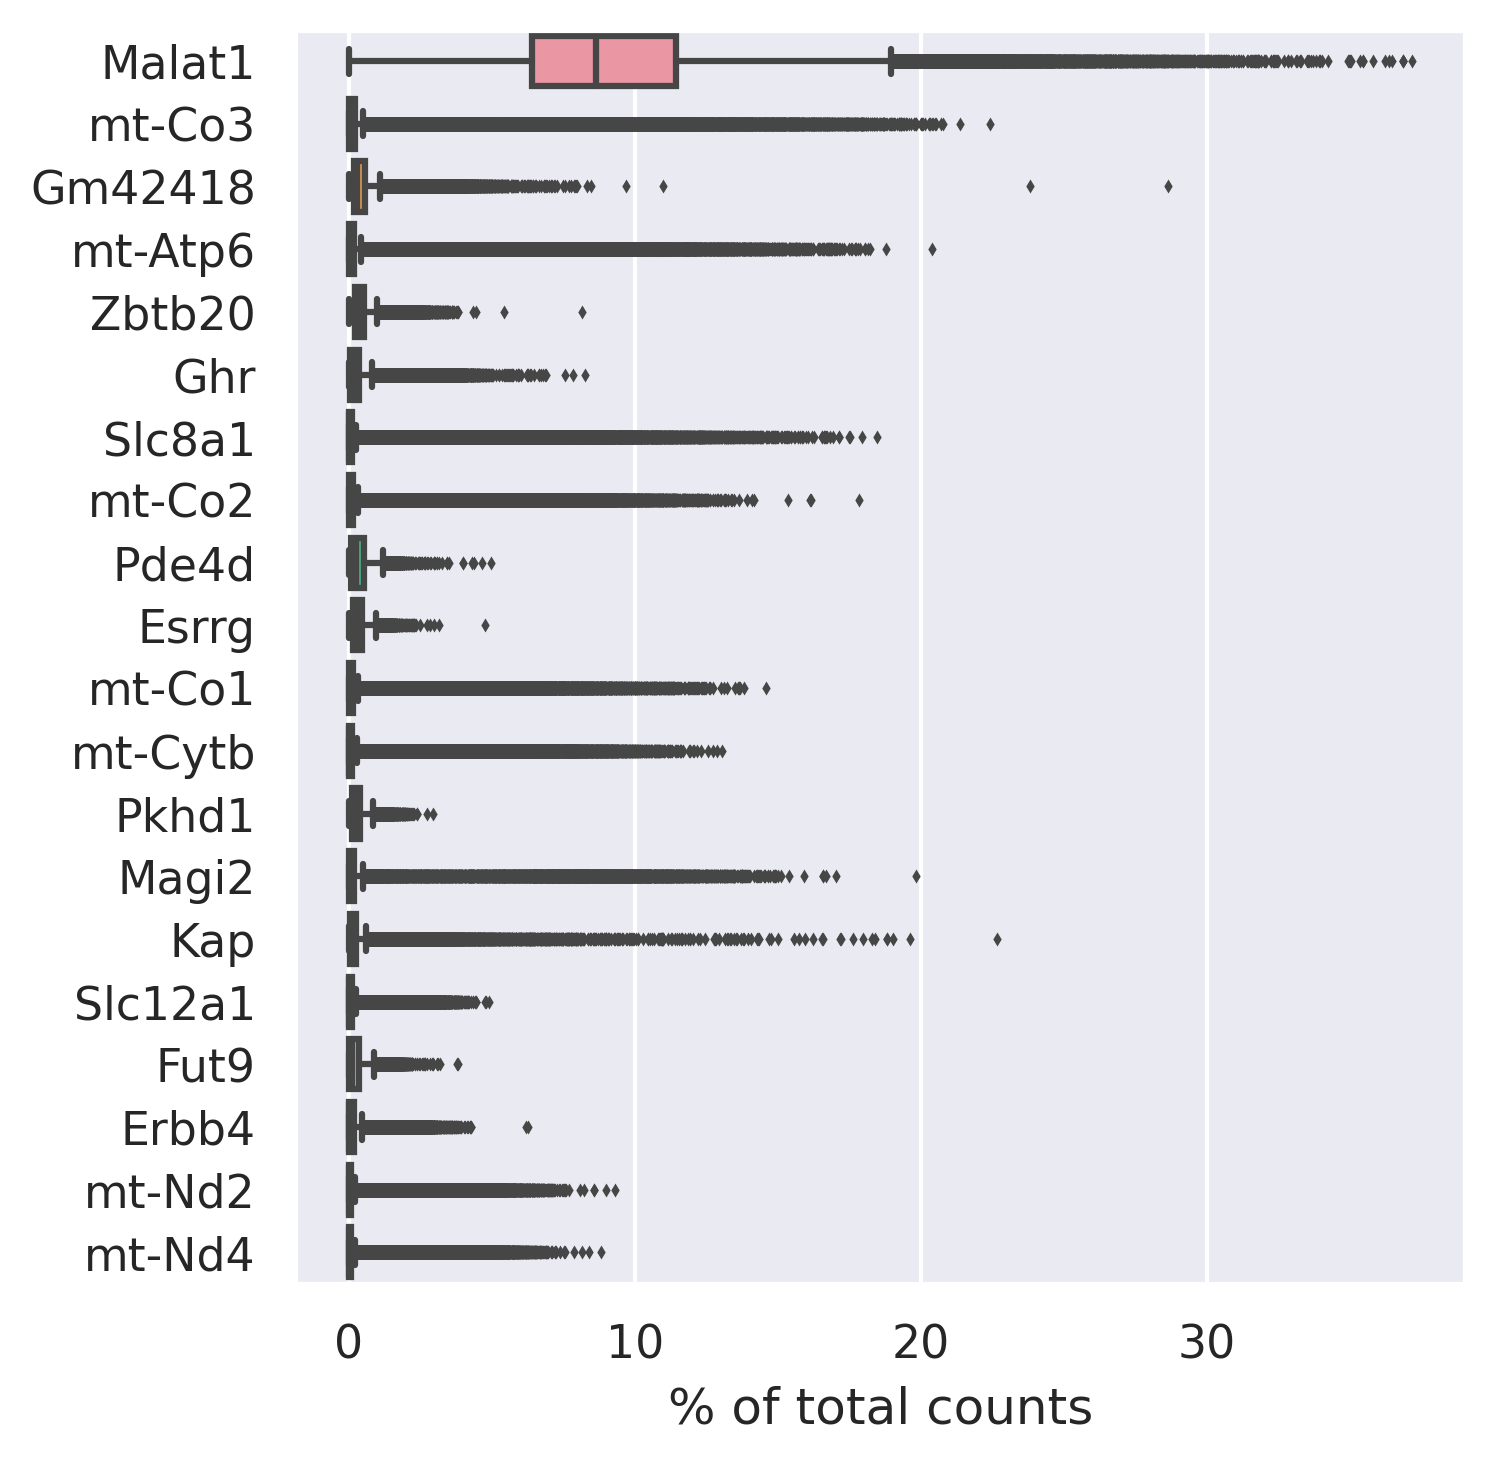

In [15]:
sns.set(font_scale = 1)

sc.pl.highest_expr_genes(adata, n_top=20 )

We can see that among the genes with the highest expression there are several mitochondrial genes: NC_002333.4, mt-co2, mt-cyb, etc. <br>
We can filter these genes using regular expression and the scanpy filtering function. 

In [16]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
# adata.var['nc'] = adata.var_names.str.startswith('NC_')

In [17]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

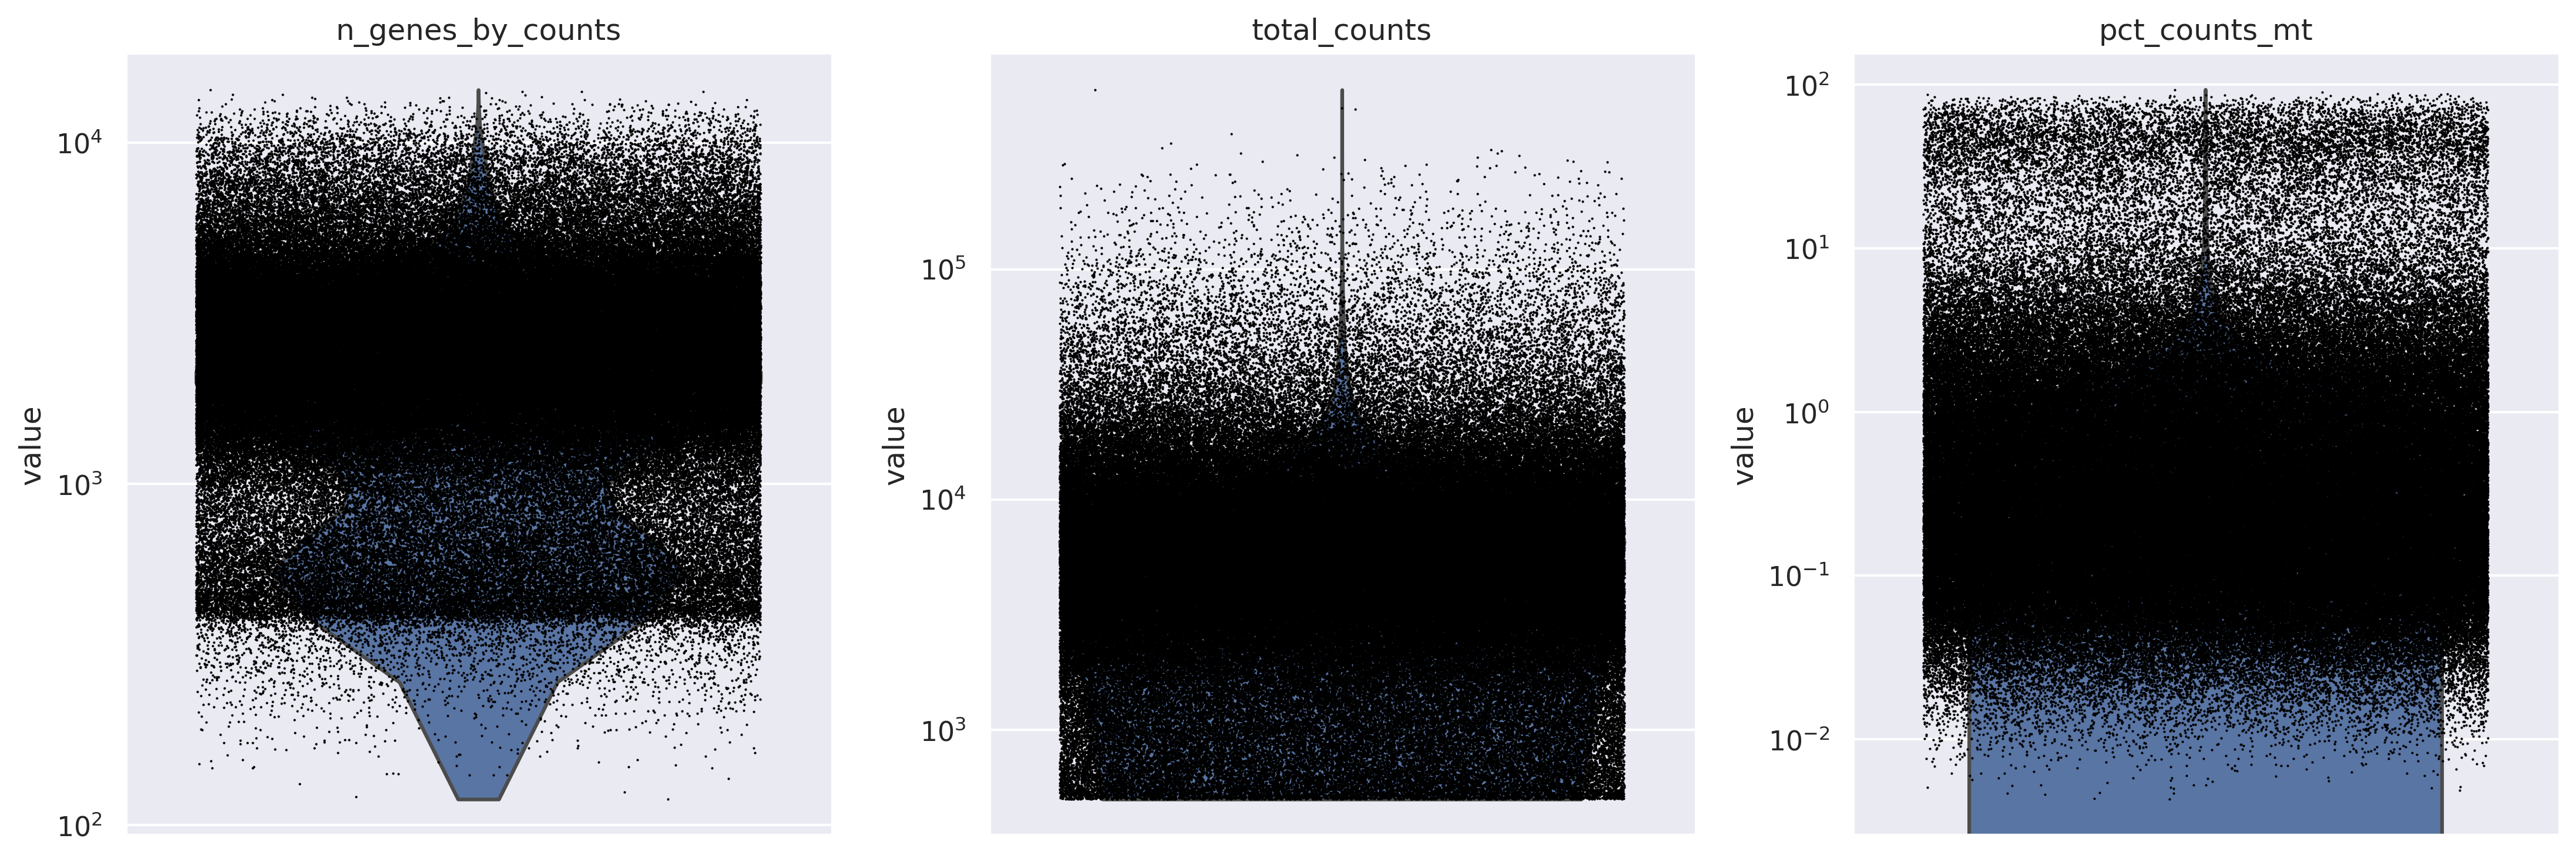

In [18]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, log =True)

### Plot all cells based on both parameters and choose a cut-off
Ideally we should do this based on the quantiles of the distribution

In [ ]:
# # Just do MT
# plt.figure(figsize=(3,3))
# sns.set_style("whitegrid")

# # adata[(adata.obs['pct_counts_nc']<20) & (adata.obs['pct_counts_mt']<20) ]

# fig, ax = plt.subplots()
# ax.set(xlabel="% NC counts", ylabel = "% MT counts") 
# ax = sc.pl.scatter(adata[(adata.obs['pct_counts_nc']<20) & (adata.obs['pct_counts_mt']<20) ], 
#                    x='pct_counts_nc', y='pct_counts_mt',alpha = 0.2, 
#                    title ='% of mitochondrial counts', ax = ax , show = False, 
#              size = 4, color ='sample_ID')


# ax.set(xlabel="% NC counts", ylabel = "% MT counts") 
# plt.show() 

<Figure size 450x450 with 0 Axes>

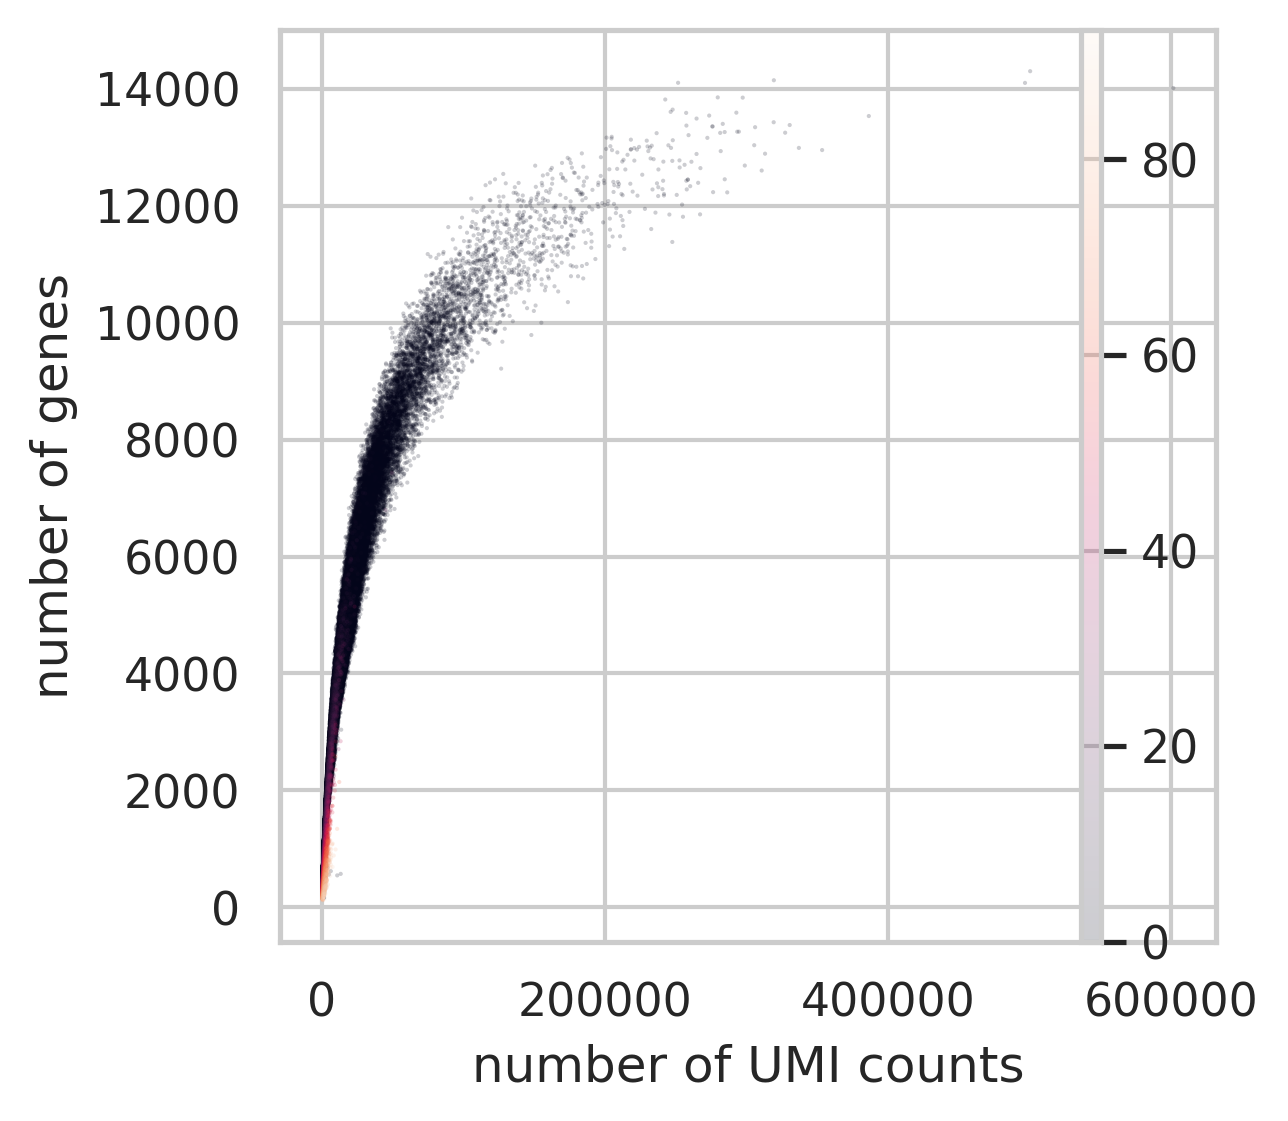

In [19]:
# A scatter plot for the number of counts (x), the number of genes (y), and % MT genes as color
plt.figure(figsize=(3,3))
sns.set_style("whitegrid")

# adata[(adata.obs['pct_counts_nc']<20) & (adata.obs['pct_counts_mt']<20) ]

fig, ax = plt.subplots()
ax.set(xlabel="number of UMI counts", ylabel = "number of genes") 
ax = sc.pl.scatter(adata, 
                   x='total_counts', y='n_genes_by_counts',alpha = 0.2, 
                   title ='', ax = ax , show = False, 
             size = 4, color ='pct_counts_mt')


ax.set(xlabel="number of UMI counts", ylabel = "number of genes") 
plt.show() 

We can see that the high MT fraction is observed for the cells that have both lower number of counts/genes.

We will zoom in the lower region to determine the QC thresholds



<Figure size 450x450 with 0 Axes>

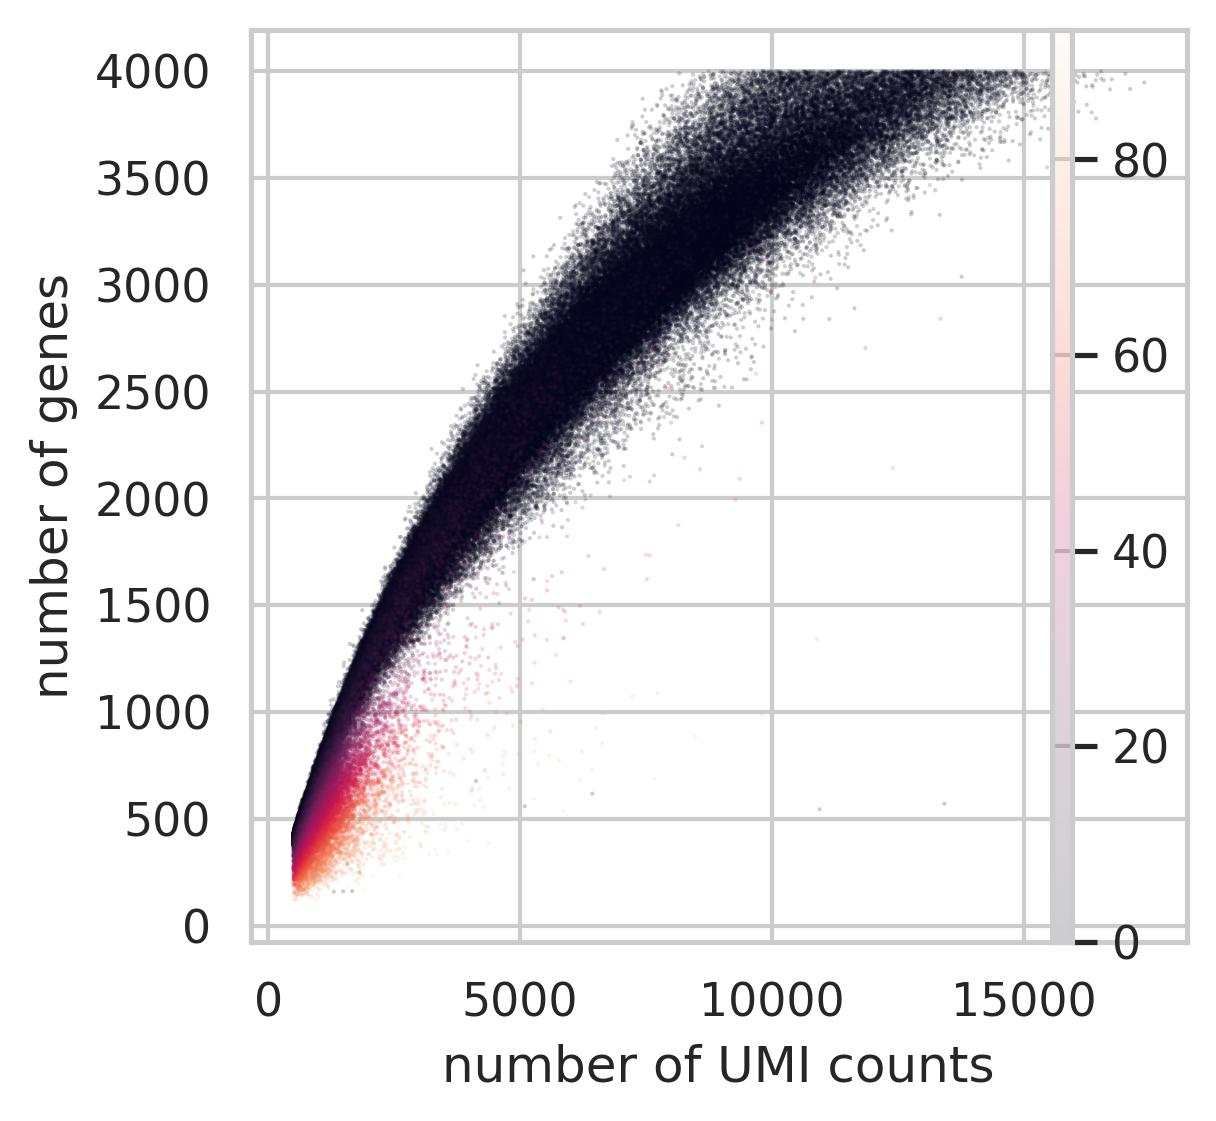

In [20]:
# A scatter plot for the number of counts (x), the number of genes (y), and % MT genes as color
plt.figure(figsize=(3,3))
sns.set_style("whitegrid")

# adata[(adata.obs['pct_counts_nc']<20) & (adata.obs['pct_counts_mt']<20) ]

fig, ax = plt.subplots()
ax.set(xlabel="number of UMI counts", ylabel = "number of genes") 
ax = sc.pl.scatter(adata[(adata.obs['total_counts']<20000) & (adata.obs['n_genes_by_counts']<4000) ], 
                   x='total_counts', y='n_genes_by_counts',alpha = 0.2, 
                   title ='', ax = ax , show = False, 
             size = 4, color ='pct_counts_mt')


ax.set(xlabel="number of UMI counts", ylabel = "number of genes") 
plt.show() 

### Let's draw the thresholds for max mitochondrial content (5 - 10% for a good sample) 

[Text(0.5, 0, 'Sample'), Text(0, 0.5, '% MT counts')]

<Figure size 4200x1200 with 0 Axes>

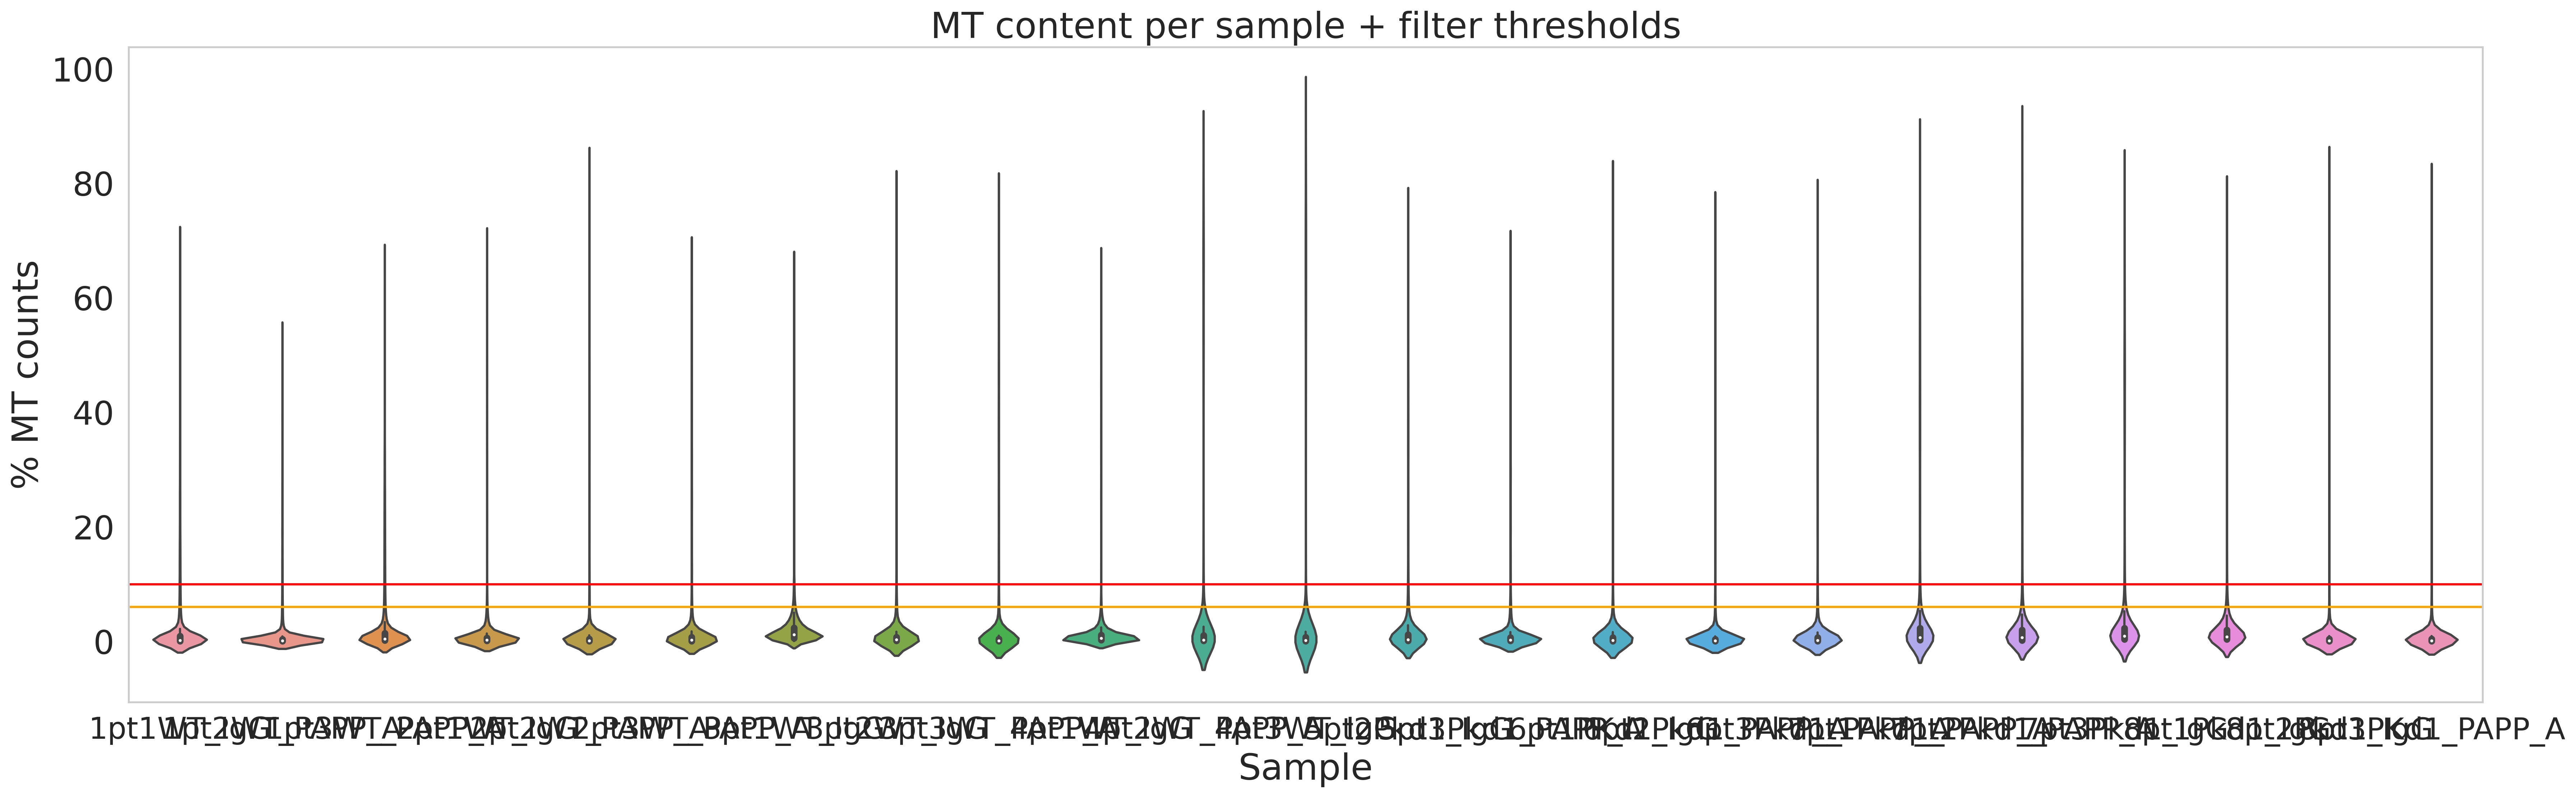

In [21]:
violin_width = 28 
violin_height = 8
plt.figure(figsize=(violin_width,violin_height))

sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})

fig, ax = plt.subplots(figsize  =(violin_width, violin_height) )
sns.violinplot(data =adata.obs, x= 'sample_ID',y='pct_counts_mt' , ax = ax )
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 20) # assign to variable to supress text

ax.axhline(y=6, color='orange', linestyle='-')
ax.axhline(y=10, color='red', linestyle='-')


plt.title('MT content per sample + filter thresholds')
ax.set(xlabel="Sample", ylabel = "% MT counts") 


# 3. Apply filters

### Summary so far 
* Based on the distribution of counts we found a minimal number (10000) and a maximum (optional, 100000) 
* We want to filter cells with high mitochondrial content (mt and NC genes): we picked 6% maximum (strict) 
* Based on the distribution of genes per cell we can also apply a filter (optional) at 2000 genes per cell minimum

In [22]:
# Apply all filters 
adata = adata[adata.obs.pct_counts_mt < 6, :]
adata = adata[adata.obs['total_counts'].between(1200,100000), :]
# adata = adata[adata.obs['total_counts']>2500, :]
adata = adata[adata.obs['n_genes'] > 2000, :]

In [23]:
adata

View of AnnData object with n_obs × n_vars = 159020 × 32285
    obs: 'n_genes', 'n_counts', 'sample_ID', 'sample_name', 'group', 'treatment', 'sex', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

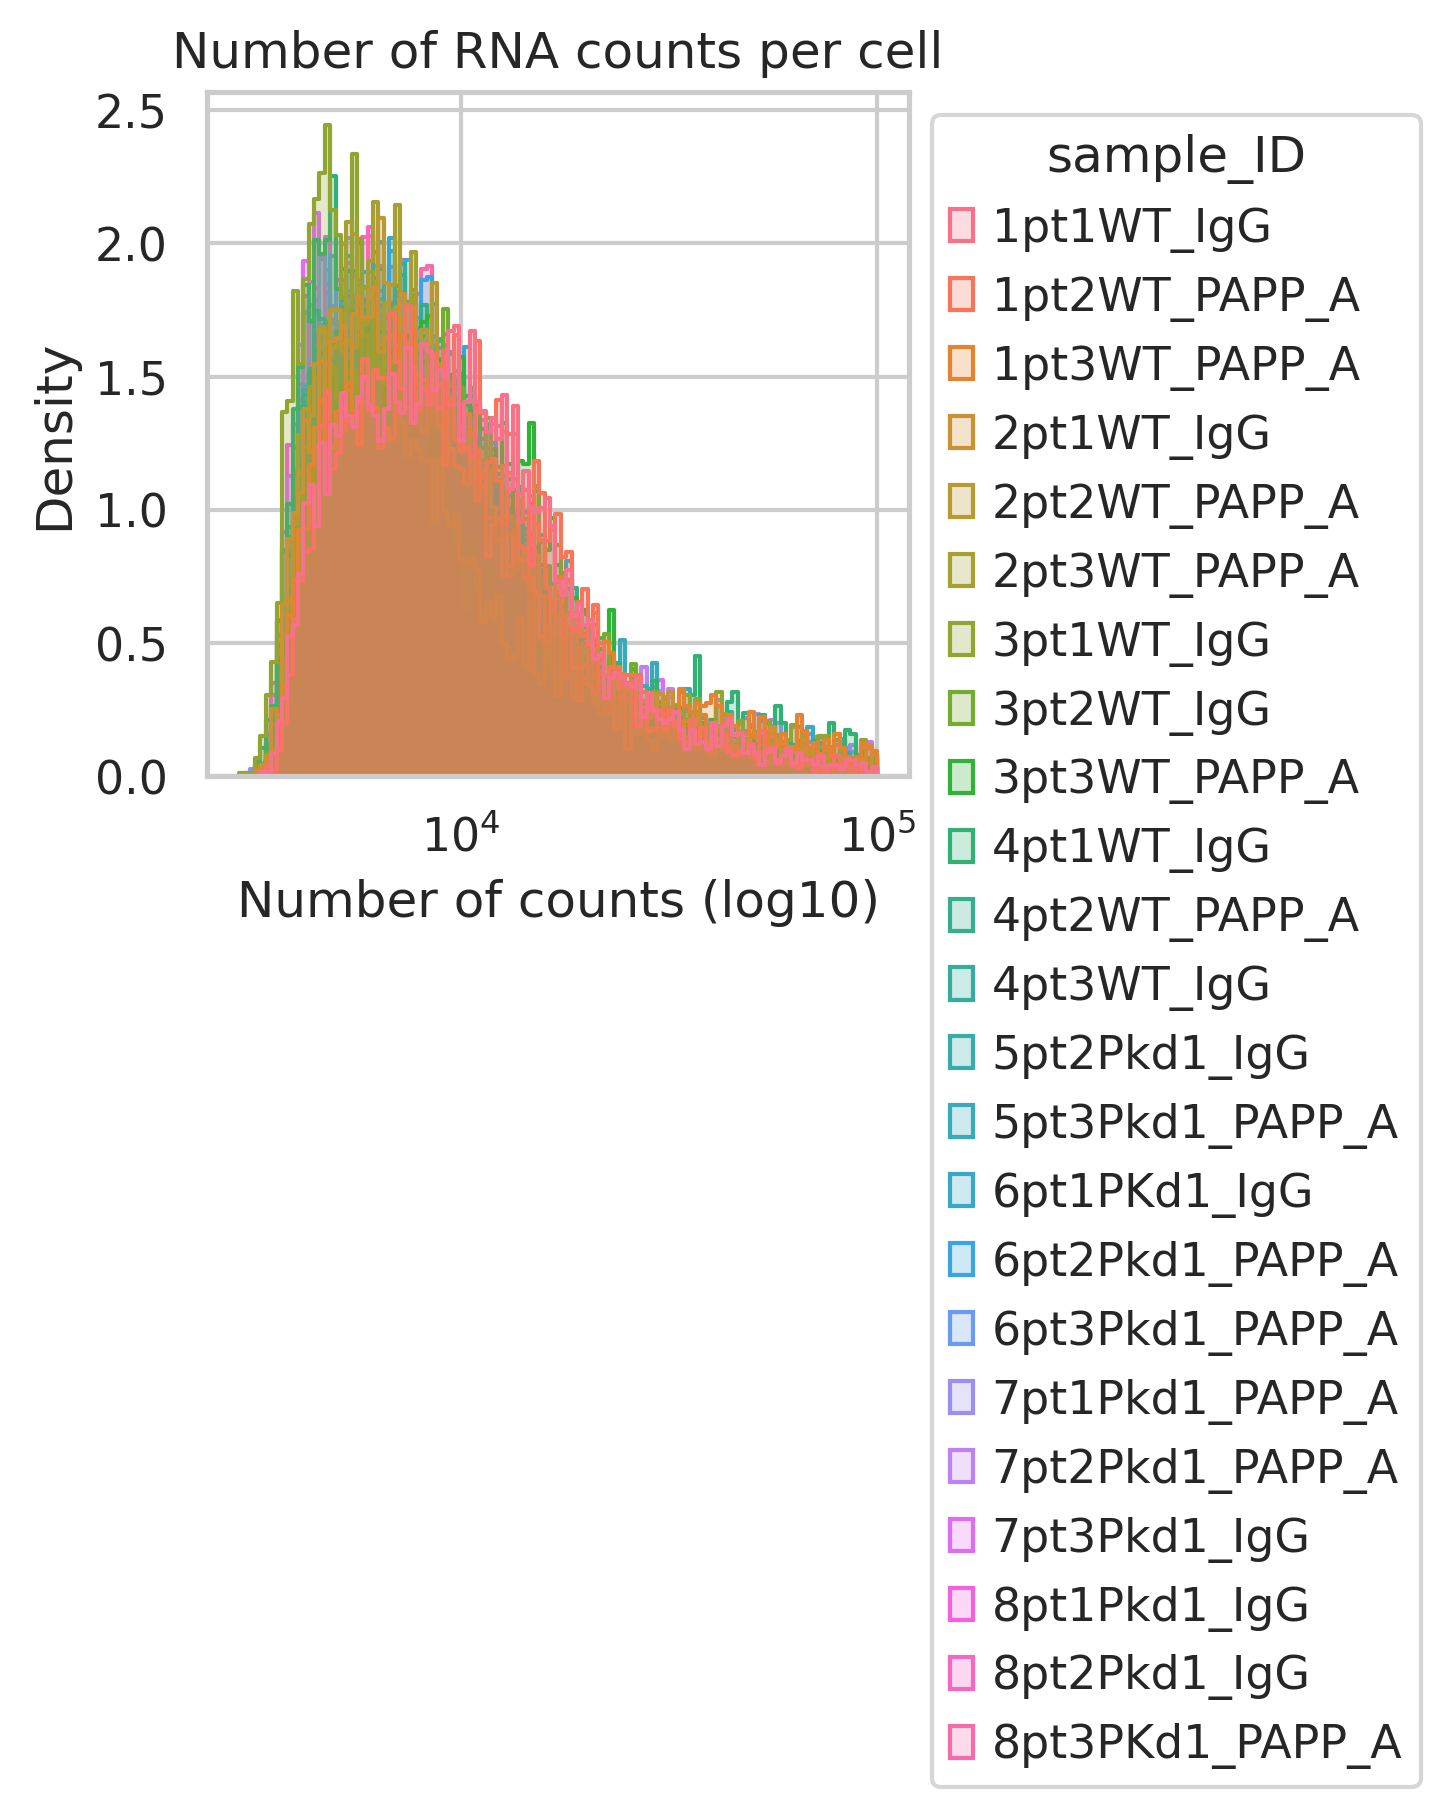

In [24]:
# Plot the histogram
plt.figure(figsize=(3,3))
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : True})


# Plot the histogram
ax = sns.histplot(adata.obs, x = 'n_counts',
             element="step", common_norm=False, kde=False, stat="density", 
             log_scale=True, hue="sample_ID", label = 'sample_ID')

ax.set_title('Number of RNA counts per cell') 
ax.set(xlabel="Number of counts (log10)") 

# Place the legend outside the plot
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [25]:
adata.obs['sample_ID'].value_counts() 

sample_ID
1pt1WT_IgG         9005
6pt3Pkd1_PAPP_A    8672
6pt1PKd1_IgG       7948
8pt1Pkd1_IgG       7797
1pt2WT_PAPP_A      7742
8pt3PKd1_PAPP_A    7498
1pt3WT_PAPP_A      7367
5pt3Pkd1_PAPP_A    7122
2pt1WT_IgG         7074
6pt2Pkd1_PAPP_A    7008
3pt2WT_IgG         6987
3pt3WT_PAPP_A      6960
4pt2WT_PAPP_A      6933
2pt3WT_PAPP_A      6910
4pt3WT_IgG         6748
7pt2Pkd1_PAPP_A    6644
8pt2Pkd1_IgG       6331
2pt2WT_PAPP_A      6078
7pt3Pkd1_IgG       5985
4pt1WT_IgG         5858
7pt1Pkd1_PAPP_A    5799
3pt1WT_IgG         5621
5pt2Pkd1_IgG       4933
Name: count, dtype: int64

# Create Anndata for label transfer which is just basic filtered but not scaled. 

In [26]:
adata.layers['counts'] = adata.X.copy() 

In [ ]:
adata.X = adata.layers['counts'].copy() # reset to raw counts to ensure we start from scratch
adata.raw = adata.copy() 

In [ ]:
ATLAS_DIR

In [ ]:
from datetime import date
today = date.today()

# mm/dd/y
d = today.strftime("%m%d%y")
print("date =", d)

adata.write(ATLAS_DIR + 'pkd10_RCRC_postQC_labeltransfer_'+d+'.h5ad')

# 4. Clustering 
We are going to apply a basic pipeline for clustering and UMAP. <br>
It won't be ready to be published but it will be a great start! <br>
For more details and parameters check out the Scanpy tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [ ]:
adata.layers['counts'] = adata.X.copy() 

<span style="color:blue">Function definition</span> <br>
This cell creates a function that we will use later, it doesn't print anything. 
<br>


In [ ]:
# a collection of scanpy functions to perform log-normalization and dimensionality reduction (PCA) and UMAP
def scanpy_vanilla(adata = [], 
                    total_count_norm = 1e4, 
                    n_pcs_max = 50,
                    use_count_layer = False, # if the object has raw counts stored, we should reset to those 
                    x_matrix_raw = True, # If this is a new object, adata.X contains raw counts 
                    ):

    adata.X = adata.layers['counts'].copy() # reset to raw counts to ensure we start from scratch
    sc.pp.normalize_total(adata, target_sum=total_count_norm)
    sc.pp.log1p(adata)

    adata.raw = adata.copy() 

    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

    sc.pp.scale(adata, max_value=10)

    sc.tl.pca(adata, n_comps = n_pcs_max, svd_solver='arpack')

    return adata

# Outputs an adata object 
def scanpy_neighbors_umap(adata = [], n_neigh  = 30, 
                    n_pcs_use = 50 , 
                    use_metric = 'cosine'):
    # use scVI latent space for UMAP generation
    sc.pp.neighbors(adata, 
                metric=use_metric, 
                n_neighbors=n_neigh, n_pcs=n_pcs_use )

    sc.tl.umap(adata, min_dist=0.3)
    sc.tl.leiden(adata )
    return adata


In [ ]:
adata = scanpy_vanilla(adata, total_count_norm = 1e4, n_pcs_max = 100) 

In [ ]:
adata = scanpy_neighbors_umap(adata, n_neigh =30, n_pcs_use = 50, use_metric = 'cosine') 

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))

sc.pl.umap(adata, color='sample_ID', add_outline=False, legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='Data clustering', 
               ax=ax, show = False)

Let's check out some of the important variables plotted on the UMAP

In [ ]:
sc.pl.umap(adata, color=['n_genes', 'n_counts'], use_raw=False)

In [ ]:
sc.pl.umap(adata, color=['group'], use_raw=False)

In [ ]:
sc.pl.umap(adata, color=['treatment'], use_raw=False)

In [ ]:
adata.obs.head() 

In [ ]:
adata

In [ ]:
from datetime import date
today = date.today()

# mm/dd/y
d = today.strftime("%m%d%y")
print("date =", d)

adata.write(ATLAS_DIR + 'pkd1-_flfl_postQC_'+d+'.h5ad')

# Packages versions

In [ ]:
# Scanpy 
sc.__version__

In [ ]:
# Seaborn
sns.__version__

In [ ]:
# Anndata
ad.__version__

In [ ]:
adata_ann1 = ad.read_h5ad("flfl_adata/pkd1-_flfl_postQC_030824.h5ad")
adata_ann1

In [ ]:
import anndata as ad

In [ ]:
adata_ann1.